In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, fbeta_score, roc_curve, confusion_matrix, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from collections import Counter
#from imblearn.over_sampling import SMOTENC

In [2]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Data loading

In [3]:
data_test = pd.read_csv('application_test.csv')
data_train = pd.read_csv('application_train.csv')
#data_bureau = pd.read_csv('bureau.csv')
#data_bureau_balance = pd.read_csv('bureau_balance.csv')
#data_card = pd.read_csv('credit_card_balance.csv')
#data_installments = pd.read_csv('installments_payments.csv')
#data_POS = pd.read_csv('POS_CASH_balance.csv')
#data_previous = pd.read_csv('previous_application.csv')
parse_dates=True

In [9]:
df_test = data_test.copy()

In [5]:
df_train = data_train.copy()

# Data Analysis

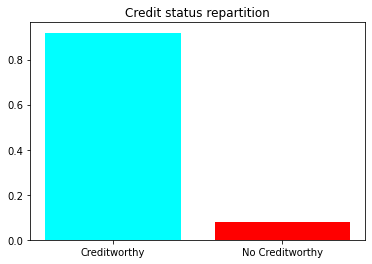

In [19]:
height = df_train["TARGET"].value_counts(normalize=True).tolist()
bars = ['Creditworthy','No Creditworthy']
x_pos = np.arange(len(bars))

# Create bars
plt.bar(x_pos, height, color=['cyan', 'red'])

# Create names on the x-axis
plt.xticks(x_pos, bars)
plt.title('Credit status repartition')
# Show graph
plt.show()

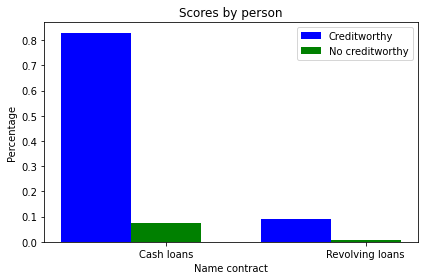

In [34]:
# data to plot
n_groups = 2
means_frank = df_train[["NAME_CONTRACT_TYPE", "TARGET"]].value_counts(normalize=True).tolist()[:2]
means_guido = df_train[["NAME_CONTRACT_TYPE", "TARGET"]].value_counts(normalize=True).tolist()[2:]

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
#opacity = 0.8

rects1 = plt.bar(index, means_frank, bar_width,
#alpha=opacity,
color='b',
label='Creditworthy')

rects2 = plt.bar(index + bar_width, means_guido, bar_width,
#alpha=opacity,
color='g',
label='No creditworthy')

plt.xlabel('Name contract')
plt.ylabel('Percentage')
plt.title('Scores by person')
plt.xticks(index + bar_width, df_train["NAME_CONTRACT_TYPE"].value_counts().index.tolist())
plt.legend()

plt.tight_layout()
plt.show()



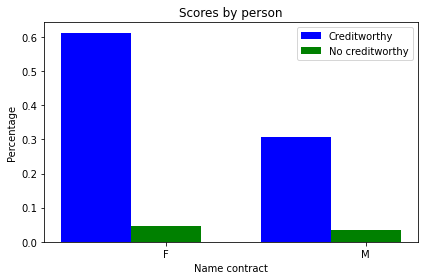

In [43]:
# data to plot
n_groups = 2
means_frank = df_train[["CODE_GENDER", "TARGET"]].value_counts(normalize=True).tolist()[:2]
means_guido = df_train[["CODE_GENDER", "TARGET"]].value_counts(normalize=True).tolist()[2:4]

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
#opacity = 0.8

rects1 = plt.bar(index, means_frank, bar_width,
#alpha=opacity,
color='b',
label='Creditworthy')

rects2 = plt.bar(index + bar_width, means_guido, bar_width,
#alpha=opacity,
color='g',
label='No creditworthy')

plt.xlabel('Name contract')
plt.ylabel('Percentage')
plt.title('Scores by person')
plt.xticks(index + bar_width, df_train["CODE_GENDER"].value_counts().index.tolist()[:2])
plt.legend()

plt.tight_layout()
plt.show()




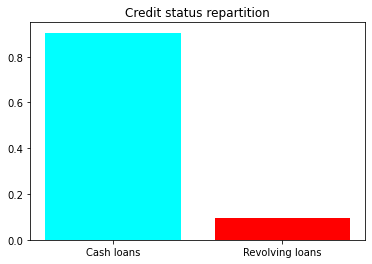

In [24]:
height = df_train["NAME_CONTRACT_TYPE"].value_counts(normalize=True).tolist()
bars = df_train["NAME_CONTRACT_TYPE"].value_counts().index.tolist()
x_pos = np.arange(len(bars))

# Create bars
plt.bar(x_pos, height, color=['cyan', 'red'])

# Create names on the x-axis
plt.xticks(x_pos, bars)
plt.title('Credit status repartition')
# Show graph
plt.show()

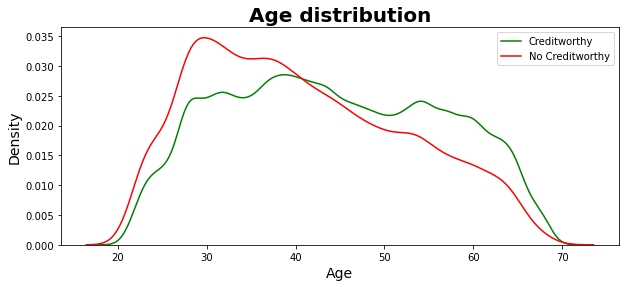

In [46]:
plt.figure(figsize = (10, 4))
sns.kdeplot(df_train[df_train['TARGET'] == 0]['DAYS_BIRTH'] / -365, label = 'Creditworthy', color='g')
sns.kdeplot(df_train[df_train['TARGET'] == 1]['DAYS_BIRTH'] / -365, label = 'No Creditworthy', color='r')

plt.legend()
plt.xlabel('Age',fontsize='14')
plt.ylabel('Density',fontsize='14')
plt.title('Age distribution', fontsize='20', fontweight='bold')
plt.show()

## Correlation

features correlated to TARGET

In [49]:
df_train.corr()['TARGET'].sort_values().tail(15)

DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

TARGET is 1 when the client didn't repay the loan and 0 when the loan was repaid

# Features Engineering

### Feature engineering - New features

In [4]:
#function to add new variables
def add_variable(data):
    data['DAYS_EMPLOYED_PERC'] = data.loc[:,'DAYS_EMPLOYED'] / data.loc[:,'DAYS_BIRTH']
    data['INCOME_CREDIT_PERC'] = data.loc[:,'AMT_INCOME_TOTAL'] / data.loc[:,'AMT_CREDIT']
    data['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / data.loc[:,'CNT_FAM_MEMBERS']
    data['ANNUITY_INCOME_PERC'] = data.loc[:,'AMT_ANNUITY'] / data.loc[:,'AMT_INCOME_TOTAL']
    data['PAYMENT_RATE'] = data.loc[:,'AMT_ANNUITY'] / data.loc[:,'AMT_CREDIT']
    #return data

In [50]:
add_variable(df_train)

# Encodage

### Split data

In [51]:
X_em = df_train.drop(['TARGET','SK_ID_CURR'], axis=1)
Y_em = df_train['TARGET'].values
X_train, X_test, y_train, y_test = train_test_split(X_em, Y_em,stratify = Y_em, test_size=0.3, random_state=42)

### Selection of features for pipeline

In [13]:
listNumerical = X_train.select_dtypes(include=['float64','int64']).columns
listCategorical = X_train.select_dtypes(include=['object']).columns
features = listNumerical.tolist() + listCategorical.tolist()

### Model Scoreboard

In [14]:
#RAJOUT VIRGULE
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

In [15]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value = 'Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse = False, drop ='first')), #trasnform column to zero,return an array,drop categories in each feature 
])

In [16]:
features_preprocessor = ColumnTransformer(
    transformers=[
     ('categorical', categorical_transformer, listCategorical),
     ('numeric', numeric_transformer, listNumerical),
     #('numeric', numeric_transformer, listNumerical.drop(['TARGET','SK_ID_CURR'])),
    ])

In [32]:
features_preprocessor.fit(df_train[features])
X_train_preproces = features_preprocessor.transform(X_train[features])
X_test_preproces = features_preprocessor.transform(X_test[features])

In [16]:
#pickle_out = open("features_preprocessor_pipeline.pkl","wb")
#pickle.dump(features_preprocessor,pickle_out)
#pickle_out.close()

## Oversampling and Undersampling

### Minority class oversampled to 0.1 of the number of examples as the majority class

In [19]:
over = SMOTE(sampling_strategy=0.1,random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5,random_state=42)
steps = [('o', over), ('u', under)]
pipeline_smote = Pipeline(steps=steps)
# transform the dataset
X_train_smote, y_train_smote = pipeline_smote.fit_resample(X_train_preproces, y_train)

In [10]:
counter = Counter(y_train)
print(counter)

Counter({0: 197880, 1: 17377})


In [20]:
counter = Counter(y_train_smote)
print(counter)

Counter({0: 39576, 1: 19788})


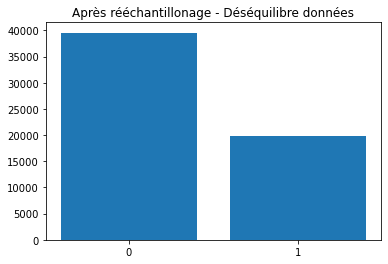

In [22]:
height = [counter[0],counter[1]]
bars = list(counter.keys())
y_pos = np.arange(len(height))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.title('Après rééchantillonage - Déséquilibre données')
#plt.savefig('après - deséquilibre.png')
plt.show()

### Scoreboard

In [31]:
results = pd.DataFrame(columns = ['Model Type','Best Score', 'AUC - Valid', 'Hyperparameters'])

### Weight calculation for positive case

In [23]:
count = Counter(y_train_smote)
# weight_1: Weight for positive case
weight_1=int(round(count[0]/count[1]))

# Models

## Random Forest

In [33]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=20, class_weight={0:1, 1:weight_1})
rf_parameters = {'max_depth': [6],  'min_samples_leaf': [1]}        # results from Optuna study
rf_grid = GridSearchCV(rf_clf, rf_parameters, cv=5, refit='ftwo', n_jobs=-1, verbose=1, scoring='roc_auc')
rf_grid.fit(X_train_smote, y_train_smote)
rf_model = rf_grid.best_estimator_
# update model scoreboard
results = pd.concat([results, pd.DataFrame.from_records([{'Model Type' : 'Random Forest',
                          'Best Score' : rf_grid.best_score_,
                          'AUC - Valid' : roc_auc_score(y_test, rf_model.predict_proba(X_test_preproces)[:, 1]),
                          'Hyperparameters' : rf_grid.best_params_}])])

Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [23]:
results

,Model Type,Best Score,AUC - Valid,Hyperparameters
0,Random Forest,0.719204,0.723876,"{'max_depth': 6, 'min_samples_leaf': 1}"
0,Random Forest,0.0,0.723876,"{'max_depth': 6, 'min_samples_leaf': 1}"


## Logistic Regression

In [35]:
lr_clf = LogisticRegression(max_iter = 300, solver = 'lbfgs', class_weight={0:1, 1:weight_1})       # lbfgs is running rings around saga

lr_parameters = {"C" : [0.005], "penalty" : ['l2']}
lr_grid = GridSearchCV(lr_clf, lr_parameters, cv=5, refit='True', n_jobs=-1, verbose=1, scoring='roc_auc')
lr_grid.fit(X_train_smote, y_train_smote)

lr_model = lr_grid.best_estimator_

# update model scoreboard
results = pd.concat([results, pd.DataFrame.from_records([{'Model Type' : 'Logistic Regression',
                          'Best Score' : lr_grid.best_score_,
                          'AUC - Valid' : roc_auc_score(y_test, lr_model.predict_proba(X_test_preproces)[:, 1]),
                          'Hyperparameters' : lr_grid.best_params_}])])

Fitting 10 folds for each of 1 candidates, totalling 10 fits


## Light GBM

In [37]:
#https://neptune.ai/blog/lightgbm-parameters-guide
params = {'boosting_type': 'gbdt', 'objective': 'binary', 'max_depth': 16,                        # choices for boosting type are 'gbdt', 'rf', 'dart', 'goss'
          'num_leaves': 30, 'learning_rate': 0.02, 'n_estimators' : 300,          # default learning rate is 0.1 but 0.02 feels like the sweet spot.
          'max_bin': 512, 'subsample_for_bin': 100, 'subsample': 0.8,
          'subsample_freq': 1, 'colsample_bytree': 0.8, 
          'reg_alpha': 80, 'reg_lambda': 20,                                                      # bumping up the alpha parameter gave us a little boost
          'min_split_gain': 0.5, 'min_child_weight': 1,
          'min_child_samples': 10, 'scale_pos_weight': 11.5, 'num_class' : 1,                     # about 92% target=0 to 8% target=1 - ratio is about 11.5 to 1
          'metric' : 'auc'
          }
    
LGB_clf = LGBMClassifier(**params, class_weight={0:1, 1:weight_1})
LGB_parameters = {'learning_rate': [0.02]}

In [38]:


LGB_grid = GridSearchCV(LGB_clf, LGB_parameters, cv=5, scoring= 'roc_auc')
LGB_grid.fit(X_train_smote, y_train_smote)
LGB_model = LGB_grid.best_estimator_

# update model scoreboard
results = pd.concat([results, pd.DataFrame.from_records([{'Model Type' : 'Light GBM',
                          'Best Score' : LGB_grid.best_score_,
                          'AUC - Valid' : roc_auc_score(y_test, LGB_model.predict_proba(X_test_preproces)[:, 1]),
                          'Hyperparameters' : LGB_grid.best_params_}])])

In [41]:
# We use F2-score (F-beta with Beta 2) overweight false negative
ftwo_scorer = make_scorer(fbeta_score, beta=2) #, pos_label=1
#accuracy_scorer = make_scorer(accuracy_score)

In [42]:

LGB_grid = GridSearchCV(LGB_clf, LGB_parameters, cv=5, scoring=ftwo_scorer)
LGB_grid.fit(X_train_smote, y_train_smote)
LGB_model = LGB_grid.best_estimator_

# update model scoreboard
results = pd.concat([results, pd.DataFrame.from_records([{'Model Type' : 'Light GBM - Beta Score - Beta 2.0',
                          'Best Score' : LGB_grid.best_score_,
                          'AUC - Valid' : roc_auc_score(y_test, LGB_model.predict_proba(X_test_preproces)[:, 1]),
                          'Hyperparameters' : LGB_grid.best_params_}])])

In [43]:
results

,Model Type,Best Score,AUC - Valid,Hyperparameters
0,Random Forest,0.719171,0.716591,"{'max_depth': 6, 'min_samples_leaf': 1}"
0,Logistic Regression,0.74571,0.750077,"{'C': 0.005, 'penalty': 'l2'}"
0,Light GBM,0.754228,0.757223,{'learning_rate': 0.02}
0,Light GBM - Beta Score - Beta 2.0,0.315378,0.757223,{'learning_rate': 0.02}


In [26]:
lgbc = LGBMClassifier(**params, class_weight={0:1, 1:weight_1})

In [27]:
lgbc.fit(X_train_smote,y_train_smote)

LGBMClassifier(class_weight={0: 1, 1: 2}, colsample_bytree=0.8,
               learning_rate=0.02, max_bin=512, max_depth=16, metric='auc',
               min_child_samples=10, min_child_weight=1, min_split_gain=0.5,
               n_estimators=300, num_class=1, num_leaves=30, objective='binary',
               reg_alpha=80, reg_lambda=20, scale_pos_weight=11.5,
               subsample=0.8, subsample_for_bin=100, subsample_freq=1)

#### Create and Saving pipeline

In [30]:
lg_pipe_final = Pipeline(steps=[
    ('preprocessor', features_preprocessor),  # preprocess features
    ('classifier', lgbc)      # apply classifier
])

#pickle_out = open("pipeline_bank.pkl","wb")
#pickle.dump(lg_pipe_final,pickle_out)
#pickle_out.close()

In [76]:
#lg_pipe = Pipeline(steps=[
#    ('preprocessor', features_preprocessor),  # preprocess features
#    ('classifier', LGBMClassifier(**params, class_weight={0:1, 1:weight_1}))      # apply classifier
#])

#### Saving LightGBM fited model

In [28]:
#pickle_out = open("lgbm_bank.pkl","wb")
#pickle.dump(lgbc,pickle_out)
#pickle_out.close()

## Loss Function

In [56]:
y_pred = lg_pipe_final.predict(X_test)
y_pred_proba = lg_pipe_final.predict_proba(X_test)[:,1]
roc_auc = round(roc_auc_score(y_test, y_pred_proba),3)

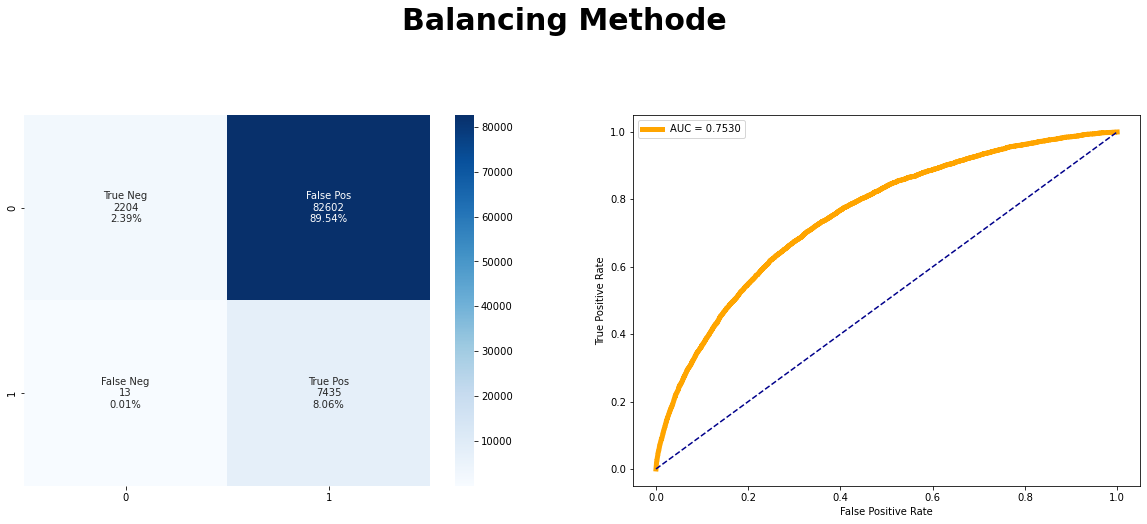

In [61]:
fig = plt.figure(figsize=(20,15))
  
plt.subplot(221)
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

plt.subplot(222)
fpr,tpr,_ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

fig.suptitle("Balancing Methode", fontsize="30", fontweight="bold")
plt.show()

In [9]:
import pickle

In [18]:
pickle_in_cl = open("lgbm_bank.pkl","rb")
classifier=pickle.load(pickle_in_cl)

# Shap - Local Features Importance

In [8]:
import shap
shap.initjs()

In [11]:
observations_preprocessed_test = lg_pipe_final['preprocessor'].transform(X_1)
explainer_test = shap.TreeExplainer(lg_pipe_final['classifier'],observations_preprocessed_test)
oneObservation = observations_preprocessed_test[0]

In [16]:
#Get columns name
columnsEncoded = lg_pipe_final['preprocessor'].transformers_[0][1][1].get_feature_names_out()

In [17]:
columnsAll = columnsEncoded.tolist() + X_1.columns.tolist()

In [341]:
Observation = observations_preprocessed[0]
#Observation = observations_preprocessed

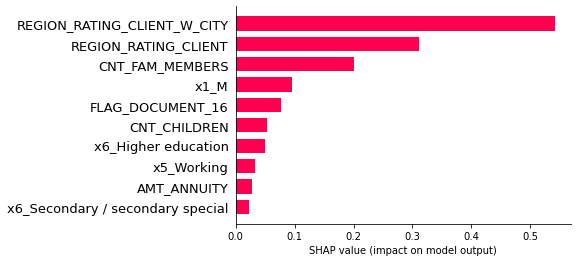

In [371]:
shap.bar_plot(explainer_test.shap_values(oneObservation),feature_names=columnsAll,max_display=10)

## Feature importance locale

In [9]:
id = 100003
X_1 = df_train[df_train['SK_ID_CURR'] == id]
X = X_1.drop(['TARGET','SK_ID_CURR'], axis=1)

In [30]:
columnsEncoded = lg_pipe_final['preprocessor'].transformers_[0][1][1].get_feature_names_out()
columnsAll = columnsEncoded.tolist() + X.columns.tolist()

In [29]:
#apply the preprocessing to x_test
observations_preprocessed = lg_pipe_final['preprocessor'].transform(X)

In [31]:
#Currently TreeExplainer can only handle models with categorical splits when feature_perturbation="tree_path_dependent" and no background data is passed
explainer = shap.TreeExplainer(lg_pipe_final['classifier'])
#explainer = shap.TreeExplainer(lg_pipe_final['classifier'],observations_preprocessed)

In [32]:
shap_values = explainer.shap_values(observations_preprocessed)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [22]:
observations_list = observations_preprocessed.tolist()

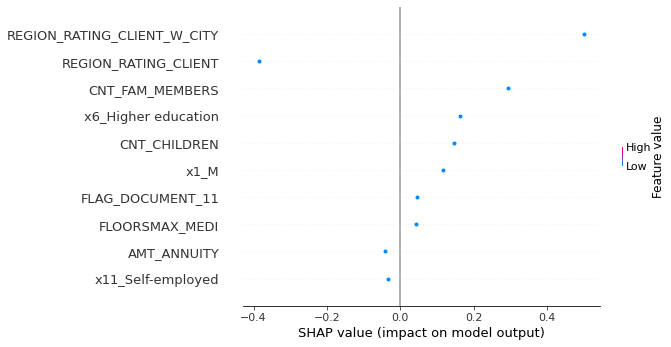

In [357]:
shap.summary_plot(shap_values[0][:], observations_preprocessed,
              feature_names=columnsAll, max_display=10)

In [55]:
explAINER = shap.TreeExplainer(lg_pipe_final['classifier'])

In [56]:
shap_ValueS = explAINER.shap_values(observations_preprocessed)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


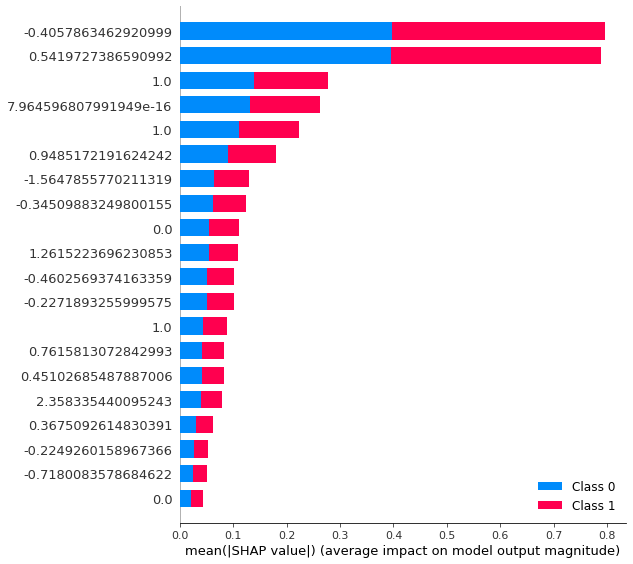

In [59]:
shap.summary_plot(shap_ValueS, oneObservation, plot_type="bar")

# Feature Importance Globale

In [64]:
#Classement des variables par ordre d'importance
features = columnsAll
features_i = list(zip(features,lg_pipe_final['classifier'].feature_importances_)) 
features_i.sort(key = lambda x : x[1]) 

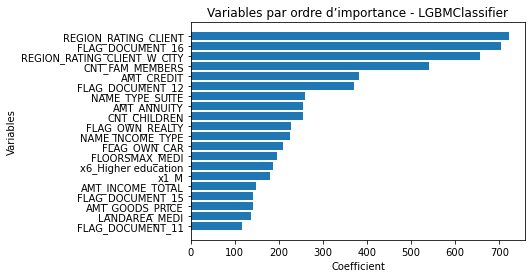

In [65]:
#Affichage des variables par ordre d'importance
plt.barh([x[0] for x in features_i[-20:]],[x[1] for x in features_i[-20:]])
plt.title('Variables par ordre d’importance - LGBMClassifier')
plt.ylabel('Variables')
plt.xlabel('Coefficient')
#plt.savefig('Coef - Random Forest Regressor SiteEnergy.png')
plt.show()